## 50.データの入手・整形

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split

FIRST_TIME = False #ファイルの保存などの処理の実行有無
DATA_PATH = "./data/news_aggregator_dataset/"

df_src = pd.read_csv(DATA_PATH + "newsCorpora_re.csv", header=None, sep="\t", names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

In [22]:
df = df_src[df_src["PUBLISHER"].isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])]

seed = 144
train_df, test_valid = train_test_split(df, test_size=0.2, shuffle=True, random_state=seed, stratify=df["CATEGORY"])
test_df, valid_df = train_test_split(test_valid, test_size=0.5, shuffle=True, random_state=seed, stratify=test_valid["CATEGORY"])

train_df.head()
print(f"train size:{train_df.shape}, valid size:{valid_df.shape}, test size:{test_df.shape}")

train size:(10684, 8), valid size:(1336, 8), test size:(1336, 8)


In [23]:
train_df = train_df.loc[:,["CATEGORY", "TITLE"]]
valid_df = valid_df.loc[:,["CATEGORY", "TITLE"]]
test_df = test_df.loc[:,["CATEGORY", "TITLE"]]

if FIRST_TIME:
    train_df.to_csv(DATA_PATH + "train.txt", sep="\t", index=False)
    valid_df.to_csv(DATA_PATH + "valid.txt", sep="\t", index=False)
    test_df.to_csv(DATA_PATH + "test.txt", sep="\t", index=False)

In [24]:
print("train:")
print(train_df['CATEGORY'].value_counts())
print("\nvalid:")
print(valid_df['CATEGORY'].value_counts())
print("\ntest")
print(test_df['CATEGORY'].value_counts())

train:
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64

valid:
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64

test
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [25]:
print(train_df.head(5))

       CATEGORY                                              TITLE
149350        b  Airline Mergers Pushed JetBlue's Pilots to Joi...
175696        e      Andrew Garfield wants Black-HispanicSpiderman
371351        b  Korean Bonds Fall as Choi Refrains From Signal...
275697        m  REFILE-AstraZeneca fights to regain cancer mar...
274356        e  Beyonce and Solange both take the plunge at fi...


## 51.特徴量抽出
TFIDFを計算し、特徴量とする

In [26]:
import string
import re

def preprocessing(text):
    text = re.sub(r"[-/:-@[-`'{-~]", r' ', text) #記号を空白に
    text = re.sub(r' {2,}', r' ', text) #2連続以上の空白を1つの空白に
    text = text.lower()
    text = re.sub(r'[0-9]+', '0', text)
    text = re.sub(r'^\s+', "", text)
    return text

print(preprocessing("Rolf Harris led 'a war on child molesters': Hypocrisy of star honoured by Queen  ..."))

rolf harris led a war on child molesters hypocrisy of star honoured by queen ...


In [27]:
train_df["TITLE"] = train_df["TITLE"].map(lambda x: preprocessing(x))
valid_df["TITLE"] = valid_df["TITLE"].map(lambda x: preprocessing(x))
test_df["TITLE"] = test_df["TITLE"].map(lambda x: preprocessing(x))

print(train_df.head(5))

       CATEGORY                                              TITLE
149350        b  airline mergers pushed jetblue s pilots to joi...
175696        e      andrew garfield wants black hispanicspiderman
371351        b  korean bonds fall as choi refrains from signal...
275697        m  refile astrazeneca fights to regain cancer mar...
274356        e  beyonce and solange both take the plunge at fi...


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

cut_off = 5
tfidf = TfidfVectorizer(min_df=cut_off, ngram_range=(1, 2))

train_vec = tfidf.fit_transform(train_df["TITLE"])
valid_vec = tfidf.transform(valid_df["TITLE"])
test_vec = tfidf.transform(test_df["TITLE"])

train_vec_df = pd.DataFrame(train_vec.toarray(), columns=tfidf.get_feature_names())
valid_vec_df = pd.DataFrame(valid_vec.toarray(), columns=tfidf.get_feature_names())
test_vec_df = pd.DataFrame(test_vec.toarray(), columns=tfidf.get_feature_names())

print(train_vec_df.head())

   0bn   0d   0k   0m  0million  0nd  0nd day  0rd   0s  0st  ...  zac efron  \
0  0.0  0.0  0.0  0.0       0.0  0.0      0.0  0.0  0.0  0.0  ...        0.0   
1  0.0  0.0  0.0  0.0       0.0  0.0      0.0  0.0  0.0  0.0  ...        0.0   
2  0.0  0.0  0.0  0.0       0.0  0.0      0.0  0.0  0.0  0.0  ...        0.0   
3  0.0  0.0  0.0  0.0       0.0  0.0      0.0  0.0  0.0  0.0  ...        0.0   
4  0.0  0.0  0.0  0.0       0.0  0.0      0.0  0.0  0.0  0.0  ...        0.0   

   zealand  zebra  zendaya  zeppelin  zero  zone  zone bond  zone bonds  \
0      0.0    0.0      0.0       0.0   0.0   0.0        0.0         0.0   
1      0.0    0.0      0.0       0.0   0.0   0.0        0.0         0.0   
2      0.0    0.0      0.0       0.0   0.0   0.0        0.0         0.0   
3      0.0    0.0      0.0       0.0   0.0   0.0        0.0         0.0   
4      0.0    0.0      0.0       0.0   0.0   0.0        0.0         0.0   

   zone inflation  
0             0.0  
1             0.0  
2       

In [29]:
if FIRST_TIME:
    train_vec_df.to_csv(DATA_PATH + "train.feature.txt", sep="\t", index=False)
    valid_vec_df.to_csv(DATA_PATH + "valid.feature.txt", sep="\t", index=False)
    test_vec_df.to_csv(DATA_PATH + "test.feature.txt", sep="\t", index=False)
# train.feature.txtは100MBを越えるのでgit管理しない 必要があればローカルで生成する

## 52.学習
ロジスティック回帰モデルを学習する

In [30]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=seed, max_iter=10000)
model.fit(train_vec_df, train_df["CATEGORY"])

LogisticRegression(max_iter=10000, random_state=144)

## 53.予測
学習したモデルを使って予測を行う

In [31]:
train_pred = model.predict(train_vec_df)
test_pred = model.predict(test_vec_df)

## 54.正解率の計算
学習データと評価データについて正解率を学習する

In [32]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train_df["CATEGORY"], train_pred)
test_accuracy = accuracy_score(test_df["CATEGORY"], test_pred)

print(f"train accuracy: {train_accuracy}")
print(f"test accuracy: {test_accuracy}")


train accuracy: 0.940752527143392
test accuracy: 0.8802395209580839


## 55.混同行列の作成

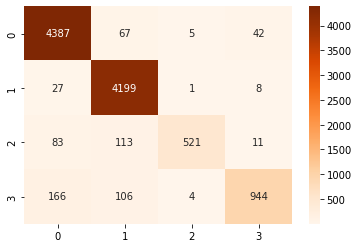

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

train_cm = confusion_matrix(train_df["CATEGORY"], train_pred)
sns.heatmap(train_cm, annot=True, cmap="Oranges", fmt="d")
plt.show()

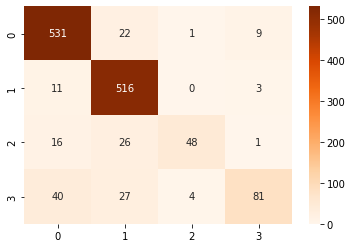

In [34]:
test_cm = confusion_matrix(test_df["CATEGORY"], test_pred)
sns.heatmap(test_cm, annot=True, cmap="Oranges", fmt="d")
plt.show()

## 適合率、再現率、F1スコアの計測
カテゴリごとに適合率、再現率、F1スコアを求め、カテゴリごとの性能をマイクロ平均とマクロ平均で統合する

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def calculate_scores(y_true, y_pred):
    labels = ['b', 'e', 't', 'm']

    #適合率
    precision = precision_score(y_true, y_pred, average=None, labels=labels)
    precision = np.append(precision, precision_score(y_true, y_pred, average="micro"))
    precision = np.append(precision, precision_score(y_true, y_pred, average="macro"))
    
    #再現率
    recall = recall_score(y_true, y_pred, average=None, labels=labels)
    recall = np.append(recall, recall_score(y_true, y_pred, average="micro"))
    recall = np.append(recall, recall_score(y_true, y_pred, average="macro"))
    
    #F1スコア
    f1 = f1_score(y_true, y_pred, average=None, labels=labels)
    f1 = np.append(f1, f1_score(y_true, y_pred, average="micro"))
    f1 = np.append(f1, f1_score(y_true, y_pred, average="macro"))
    
    scores = pd.DataFrame({"適合率":precision, "再現率":recall, "F1スコア":f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])
    return scores

print(calculate_scores(test_df["CATEGORY"], test_pred))

             適合率       再現率     F1スコア
b       0.887960  0.943162  0.914729
e       0.873096  0.973585  0.920607
t       0.861702  0.532895  0.658537
m       0.905660  0.527473  0.666667
マイクロ平均  0.880240  0.880240  0.880240
マクロ平均   0.882105  0.744278  0.790135


## 57.特徴量の重みの確認
重みのトップ10とワースト10を表示する

In [36]:
train_features = train_vec_df.columns.values

for c, coef in zip(model.classes_, model.coef_):
    print(f"カテゴリ：{c}")
    best10 = pd.DataFrame(train_features[np.argsort(coef)[::-1][:10]], columns=["best"], index=list(range(1,11))).T
    worst10 = pd.DataFrame(train_features[np.argsort(coef)[:10]], columns=["worst"], index=list(range(1,11))).T
    display(pd.concat([best10, worst10], axis=0))
    print("\n")

カテゴリ：b


,1,2,3,4,5,6,7,8,9,10
best,fed,china,stocks,ecb,bank,ukraine,euro,profit,oil,yellen
worst,google,and,her,ebola,study,apple,aereo,she,tv,microsoft




カテゴリ：e


,1,2,3,4,5,6,7,8,9,10
best,kardashian,her,chris,movie,he,star,film,kim,paul,she
worst,update,us,google,china,gm,says,ceo,study,facebook,apple




カテゴリ：m


,1,2,3,4,5,6,7,8,9,10
best,ebola,cancer,study,drug,fda,mers,health,cdc,could,cases
worst,facebook,gm,apple,deal,sales,climate,ceo,google,bank,china




カテゴリ：t


,1,2,3,4,5,6,7,8,9,10
best,google,facebook,apple,microsoft,climate,gm,tesla,nasa,heartbleed,comcast
worst,stocks,fed,drug,her,american,cancer,ecb,ukraine,percent,day


## 58.正則化パラメータの変更
異なる正則化パラメータでロジスティック回帰を学習し、結果をまとめる

In [37]:
from tqdm import tqdm

result = []
for C in tqdm(np.logspace(-5, 3, 9, base=10)):
    model = LogisticRegression(random_state=seed, max_iter=10000, C=C)
    model.fit(train_vec_df, train_df["CATEGORY"])
    
    train_pred = model.predict(train_vec_df)
    valid_pred = model.predict(valid_vec_df)
    test_pred = model.predict(test_vec_df)
    
    train_accuracy = accuracy_score(train_df["CATEGORY"], train_pred)
    valid_accuracy = accuracy_score(valid_df["CATEGORY"], valid_pred)
    test_accuracy = accuracy_score(test_df["CATEGORY"], test_pred)
    
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 9/9 [02:44<00:00, 18.30s/it]


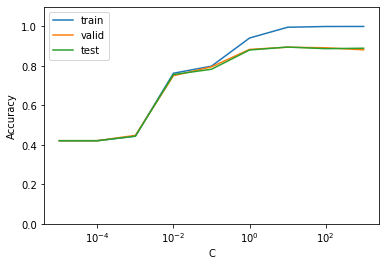

In [38]:
result = np.array(result).T
plt.plot(result[0], result[1], label="train")
plt.plot(result[0], result[2], label="valid")
plt.plot(result[0], result[3], label="test")
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

## 59.ハイパーパラメータの探索
検証データ上の正解率が最も高くなる学習パラメータを求める

In [39]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
import optuna

# 最適化対象
def objective(trial):
    c = trial.suggest_loguniform('C', 1e-2, 1e2)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    
    model = LogisticRegression(random_state=seed, max_iter=10000, l1_ratio=l1_ratio, C=c, penalty="elasticnet", solver="saga")
    model.fit(train_vec_df, train_df["CATEGORY"])
    
    valid_pred = model.predict(valid_vec_df)
    valid_accuracy = accuracy_score(valid_df["CATEGORY"], valid_pred)
    
    return valid_accuracy

In [40]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

print("BEST TRIAL")
print(f"valid score: {study.best_trial.value}")
print(f"params")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

[I 2023-05-17 00:32:03,327] A new study created in memory with name: no-name-a403ff55-e638-43c9-846f-25a3f8f99823
[I 2023-05-17 00:32:35,166] Trial 0 finished with value: 0.6182634730538922 and parameters: {'C': 0.015274261254721219, 'l1_ratio': 0.14677298333037114}. Best is trial 0 with value: 0.6182634730538922.
[I 2023-05-17 00:33:35,246] Trial 1 finished with value: 0.8802395209580839 and parameters: {'C': 0.975749428368976, 'l1_ratio': 0.04961078145874276}. Best is trial 1 with value: 0.8802395209580839.
[I 2023-05-17 00:38:05,930] Trial 2 finished with value: 0.8929640718562875 and parameters: {'C': 4.366416259846738, 'l1_ratio': 0.8261526616271835}. Best is trial 2 with value: 0.8929640718562875.
[I 2023-05-17 00:38:35,789] Trial 3 finished with value: 0.6369760479041916 and parameters: {'C': 0.047022054024654196, 'l1_ratio': 0.8862127405911339}. Best is trial 2 with value: 0.8929640718562875.
[I 2023-05-17 00:40:54,998] Trial 4 finished with value: 0.8922155688622755 and parame

BEST TRIAL
valid score: FrozenTrial(number=2, values=[0.8929640718562875], datetime_start=datetime.datetime(2023, 5, 17, 0, 33, 35, 247197), datetime_complete=datetime.datetime(2023, 5, 17, 0, 38, 5, 930634), params={'C': 4.366416259846738, 'l1_ratio': 0.8261526616271835}, distributions={'C': FloatDistribution(high=100.0, log=True, low=0.01, step=None), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=2, state=TrialState.COMPLETE, value=None)
params
    C: 4.366416259846738
    l1_ratio: 0.8261526616271835


In [41]:
# パラメータの設定
l1_ratio = study.best_trial.params['l1_ratio']
c = study.best_trial.params['C']

# モデルの学習
model = LogisticRegression(random_state=seed, 
                        max_iter=10000,
                        l1_ratio=l1_ratio, 
                        C=c,
                        penalty="elasticnet",
                        solver="saga")
model.fit(train_vec_df, train_df['CATEGORY'])

# 予測値の取得
train_pred = model.predict(train_vec_df)
valid_pred = model.predict(valid_vec_df)
test_pred = model.predict(test_vec_df)

# 正解率の算出
train_accuracy = accuracy_score(train_df['CATEGORY'], train_pred) 
valid_accuracy = accuracy_score(valid_df['CATEGORY'], valid_pred) 
test_accuracy = accuracy_score(test_df['CATEGORY'], test_pred) 

print(f'正解率（学習データ）：{train_accuracy:.3f}')
print(f'正解率（検証データ）：{valid_accuracy:.3f}')
print(f'正解率（評価データ）：{test_accuracy:.3f}')

正解率（学習データ）：0.982
正解率（検証データ）：0.893
正解率（評価データ）：0.891
